In [1]:
import cv2
import os
import random
import glob as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *

In [2]:
zip_file_path = 'MoodforMusic.zip'
extract_to_path = 'MoodforMusic'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)
extracted_files = os.listdir(extract_to_path)
print(extracted_files)

['data_moods.csv', 'test', 'train']


In [3]:
train_data="../MoodforMusic/train/"
test_data="../MoodforMusic/test/"

def Classes_Count(path, name):
    Classes_Dict={}
    for Class in os.listdir(path):
        Full_Path = path+Class
        Classes_Dict[Class]=len(os.listdir(Full_Path))
    df=pd.DataFrame(Classes_Dict, index=[name])
    return df

Train_Count= Classes_Count(train_data, "Train").transpose().sort_values(by="Train",ascending=False)
Test_Count= Classes_Count(test_data, "Test").transpose().sort_values(by="Test",ascending=False)

In [4]:
pd.concat([Train_Count,Test_Count], axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1248
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

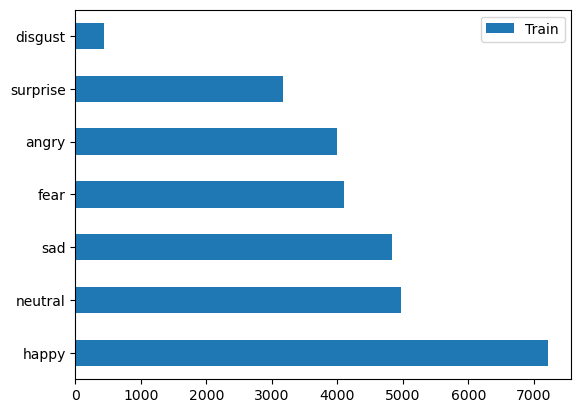

In [5]:
Train_Count.plot(kind="barh")

<Axes: >

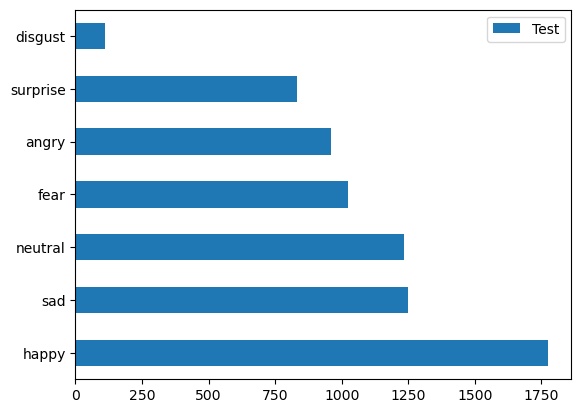

In [6]:
Test_Count.plot(kind="barh")

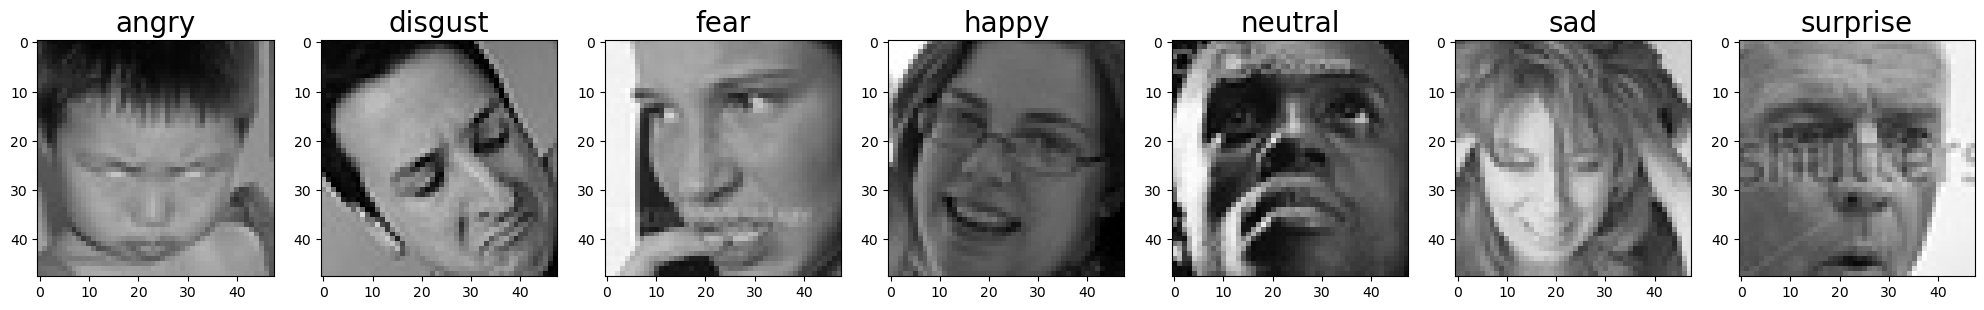

In [7]:
plt.style.use("default")
plt.figure(figsize=(25,8))
image_count=1
BASE_URL = "../MoodforMusic/train/"

for directory in os.listdir(BASE_URL):
    if directory[0] != ".":
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1,7, image_count)
                image_count+=1
                image=cv2.imread(BASE_URL+directory+"/"+file)
                plt.imshow(image)
                plt.title(directory, fontsize=20)

In [8]:
img_shape=48
batch_size=32
train_data_path="../MoodforMusic/train/"
test_data_path="../MoodforMusic/test/"

In [9]:
train_preprocessor = ImageDataGenerator(
    rescale=1.0/255.0, 
    rotation_range=10, 
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest")

test_preprocessor = ImageDataGenerator(
    rescale=1.0/255.0)

training_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode='categorical',
    target_size=(img_shape, img_shape),
    batch_size=batch_size,
    color_mode="rgb",
    shuffle=True,
    subset="training"
)

testing_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode='categorical',
    target_size=(img_shape, img_shape),
    batch_size=batch_size,
    color_mode="rgb",
    shuffle=False,
)

Found 28709 images belonging to 7 classes.
Found 7179 images belonging to 7 classes.


In [10]:
def Create_CNN_Model():
    model=keras.Sequential()
    model.add(Conv2D(32,(3,3),activation="relu", input_shape=(img_shape, img_shape,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(Dropout(0.25))
    model.add(Conv2D(64,(3,3),activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(Dropout(0.25))
    model.add(Conv2D(128,(3,3),activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3),activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(7,activation='softmax'))
    return model    

In [11]:
CNN_Model=Create_CNN_Model()
CNN_Model.summary()
CNN_Model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 9, 9, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,259,655 (8.62 MB)

 Trainable params: 2,257,351 (8.61 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [12]:
checkpoint_path="CNN_Model_Checkpoint.keras"
Checkpoint=ModelCheckpoint(checkpoint_path,monitor="val_accuracy",save_best_only=True)
Early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
Reducing_LR=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2,min_lr=0.000005, verbose=1)
callbacks=[Early_stopping, Reducing_LR]
steps_per_epoch=training_data.n//training_data.batch_size
validation_steps=testing_data.n//testing_data.batch_size

In [13]:
CNN_history=CNN_Model.fit(training_data,validation_data=testing_data,epochs=40, batch_size=batch_size, 
                          callbacks=callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/40
897/897 ━━━━━━━━━━━━━━━━━━━━ 263s 270ms/step - accuracy: 0.2028 - loss: 2.1480 - val_accuracy: 0.3449 - val_loss: 1.6442 - learning_rate: 0.0010
Epoch 2/40
897/897 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.2188 - loss: 1.8399 - val_accuracy: 0.3464 - val_loss: 1.6437 - learning_rate: 0.0010
Epoch 3/40
897/897 ━━━━━━━━━━━━━━━━━━━━ 231s 257ms/step - accuracy: 0.3126 - loss: 1.7219 - val_accuracy: 0.3258 - val_loss: 1.7316 - learning_rate: 0.0010
Epoch 4/40
  1/897 ━━━━━━━━━━━━━━━━━━━━ 3:21 225ms/step - accuracy: 0.3125 - loss: 1.7691
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
897/897 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.3125 - loss: 1.7691 - val_accuracy: 0.3297 - val_loss: 1.7180 - learning_rate: 0.0010
Epoch 5/40
897/897 ━━━━━━━━━━━━━━━━━━━━ 246s 274ms/step - accuracy: 0.3725 - loss: 1.5939 - val_accuracy: 0.4428 - val_loss: 1.4286 - learning_rate: 2.0000e-04
Epoch 6/40
897/897 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy

In [14]:
CNN_Model.save('CNN_Model_App.keras')

In [15]:
test_loss, test_acc = CNN_Model.evaluate(testing_data)
print(f'Test accuracy: {test_acc:.2f}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.5514 - loss: 1.1355
Test accuracy: 0.61


In [16]:
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
    
    plt.show()

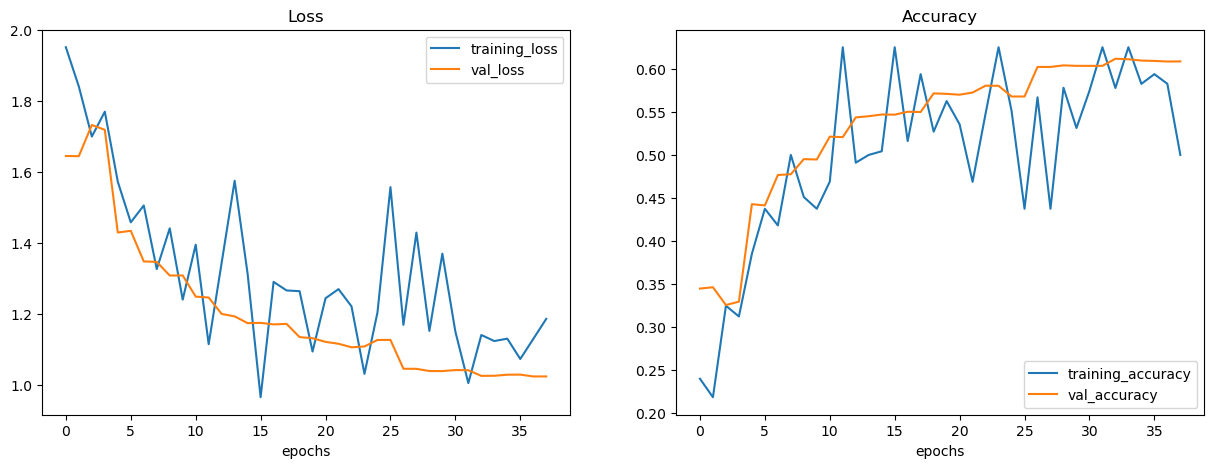

In [17]:
plot_curves(CNN_history)

In [18]:
CNN_Predictions=CNN_Model.predict(testing_data)
CNN_Predictions=np.argmax(CNN_Predictions,axis=1)

225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step


In [19]:
testing_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

Text(0.5, 1.0, 'CNN Confusion Matrix')

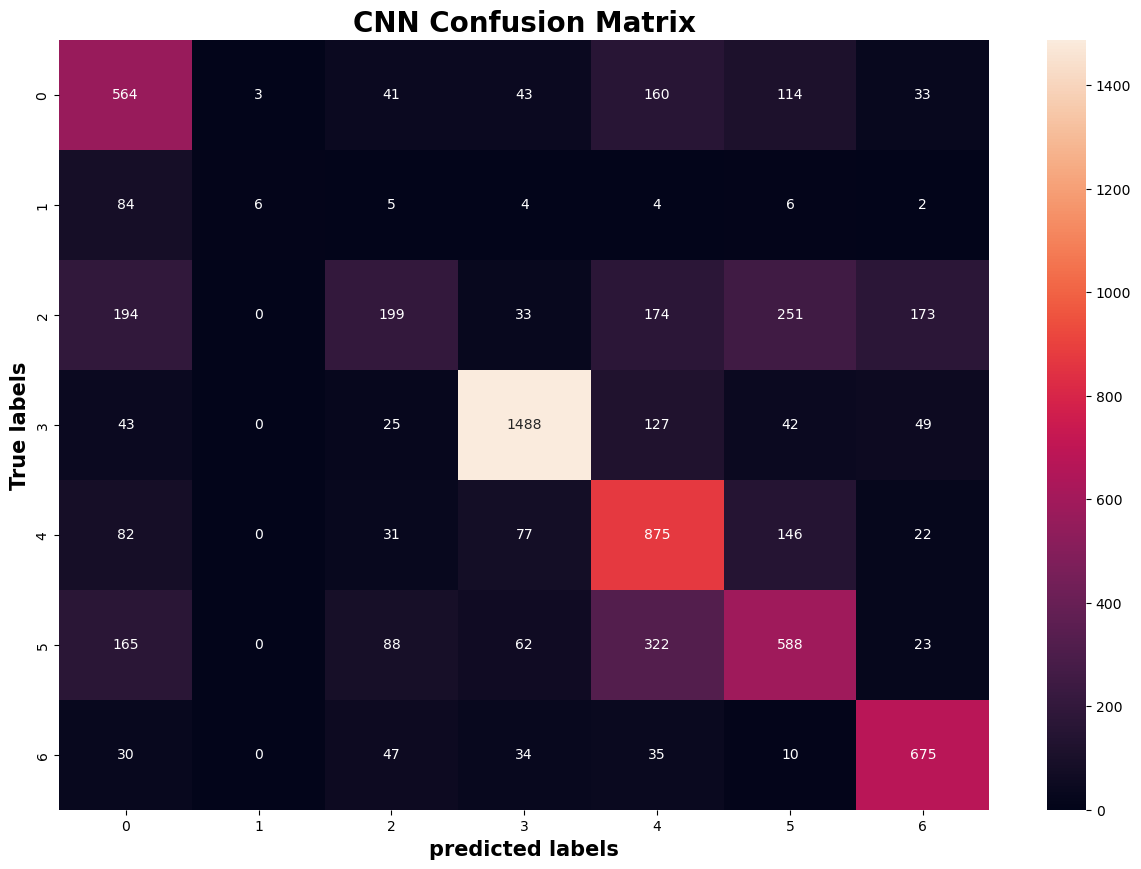

In [20]:
fig, ax=plt.subplots(figsize=(15,10))
cm=confusion_matrix(testing_data.labels,CNN_Predictions)
sns.heatmap(cm, annot=True, fmt="g", ax=ax)
ax.set_xlabel("predicted labels",fontsize=15, fontweight="bold")
ax.set_ylabel("True labels",fontsize=15, fontweight="bold")
ax.set_title("CNN Confusion Matrix",fontsize=20, fontweight="bold")

In [21]:
Emotion_Classes=["Angry",
                "Disgust",
                "Fear",
                "Happy",
                "Neutral",
                "Sad",
                "Surprise"]

In [22]:
test_preprocessor=ImageDataGenerator(rescale=1/255.,)
test_generator=test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7179 images belonging to 7 classes.


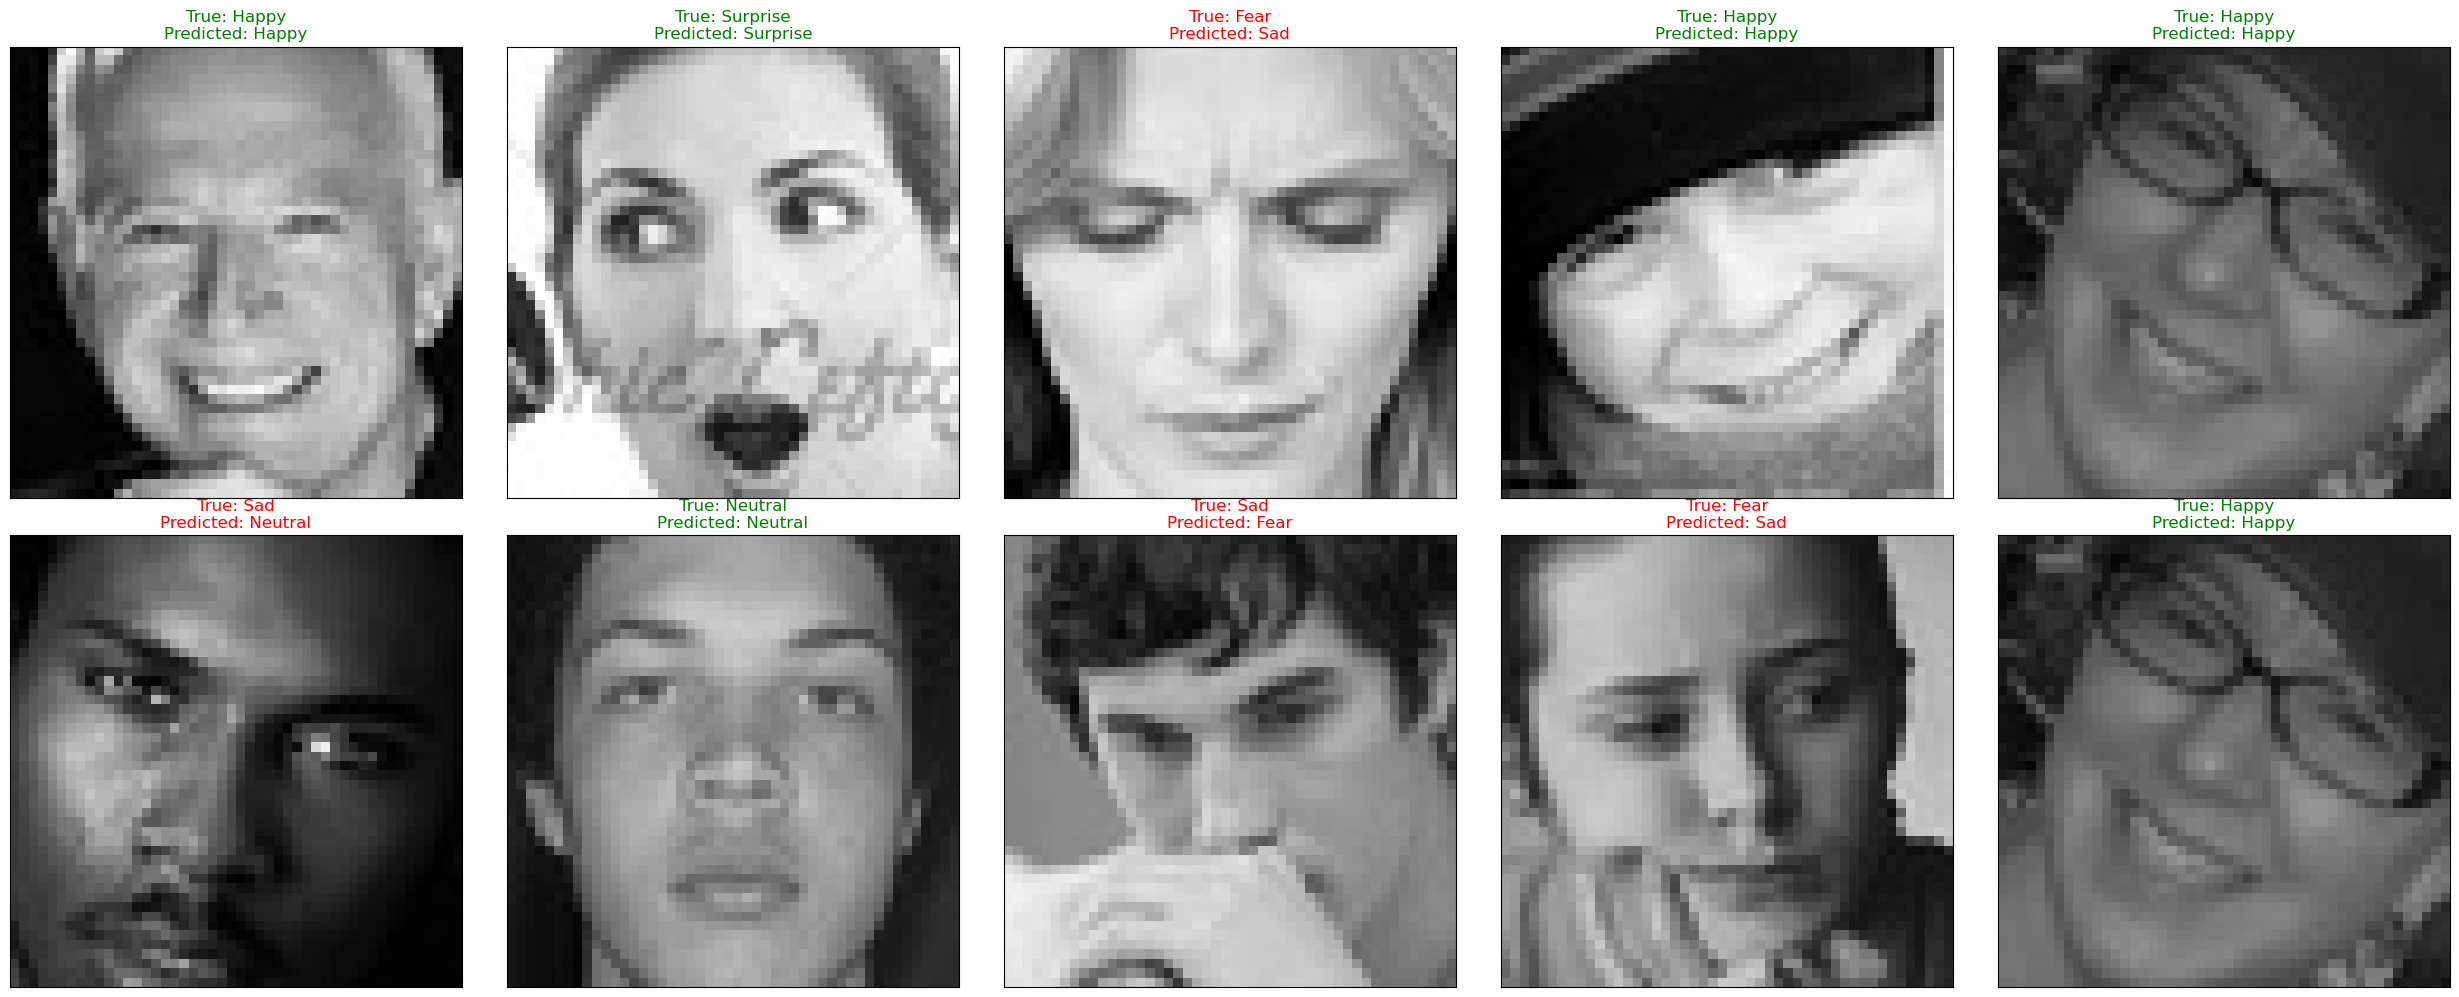

In [23]:
Random_batch = np.random.randint(0, len(test_generator) - 1)
Random_Img_Index = np.random.randint(0, batch_size - 1, 10)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10), subplot_kw={"xticks": [], "yticks": []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])
    Model_Prediction = np.argmax(CNN_Model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0))
    ax.imshow(Random_Img)
    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()


In [24]:
import urllib.request

url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"
filename = "haarcascade_frontalface_default.xml"
urllib.request.urlretrieve(url, filename)
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [25]:
Music_Player=pd.read_csv("../MoodforMusic/data_moods.csv")
Music_Player=Music_Player[["name","artist","mood","popularity"]]
Music_Player.head()

,name,artist,mood,popularity
0,1999,Prince,Happy,68
1,23,Blonde Redhead,Sad,43
2,9 Crimes,Damien Rice,Sad,60
3,99 Luftballons,Nena,Happy,2
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic,60


In [26]:
Music_Player["mood"].value_counts()

mood
Sad          197
Calm         195
Energetic    154
Happy        140
Name: count, dtype: int64

In [27]:
Music_Player["popularity"].value_counts()

popularity
0     92
51    23
52    22
50    21
55    21
      ..
80     1
2      1
14     1
15     1
88     1
Name: count, Length: 83, dtype: int64

In [28]:
Play=Music_Player[Music_Player["mood"]=="Calm"]
Play=Play.sort_values(by="popularity",ascending=False)
Play=Play[:5].reset_index(drop=True)
display(Play)

,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Curiosity,Beau Projet,Calm,60
2,Escaping Time,Benjamin Martins,Calm,60
3,Just Look at You,369,Calm,59
4,Vague,Amaranth Cove,Calm,59


In [29]:
def Recommend_Songs(pred_class):
    mood_map = {
        "Disgust": "Sad",
        "Happy": "Happy",
        "Sad": "Happy",
        "Fear": "Calm",
        "Angry": "Calm",
        "Surprise": "Energetic",
        "Neutral": "Energetic"
    }

    mood = mood_map.get(pred_class, "Happy")  # Default to "Happy" if pred_class not found
    Play = Music_Player[Music_Player["mood"] == mood]
    Play = Play.sort_values(by="popularity", ascending=False)
    Play = Play[:5].reset_index(drop=True)
    display(Play)

In [30]:
def load_and_prep_image(filename, img_shape=48):
    # Load the image
    img = cv2.imread(filename)
    if img is None:
        print(f"Error: Unable to load image at path {filename}")
        return None
    
    # Convert the image to grayscale
    GrayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)
    for x, y, w, h in faces:
        roi_GrayImg = img[y: y + h, x: x + w]
        roi_Img = img[y: y + h, x: x + w]
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Display the detected face
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Further face detection within the ROI
        faces = faceCascade.detectMultiScale(roi_Img, 1.1, 4)
        if len(faces) == 0:
            print("No additional faces detected within the ROI")
        else:
            for (ex, ey, ew, eh) in faces:
                img = roi_Img[ey: ey + eh, ex: ex + ew]

    # Convert the image to RGB
    RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize the image
    RGBImg = cv2.resize(RGBImg, (img_shape, img_shape))
    
    # Normalize the image
    RGBImg = RGBImg / 255.0

    return RGBImg

In [31]:
def pred_and_plot(filename, class_names):
    # Load and prepare the image
    img = load_and_prep_image(filename)
    
    # Check if the image is loaded correctly
    if img is None:
        print(f"Error: Unable to process the image at path {filename}")
        return
    
    # Make prediction
    pred = CNN_Model.predict(np.expand_dims(img, axis=0))
    pred_class = class_names[pred.argmax()]
    
    # Plot the image with prediction
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis('off')  # Remove the axis
    
    # Display the plot
    plt.show()
    
    # Recommend songs based on the prediction
    Recommend_Songs(pred_class)

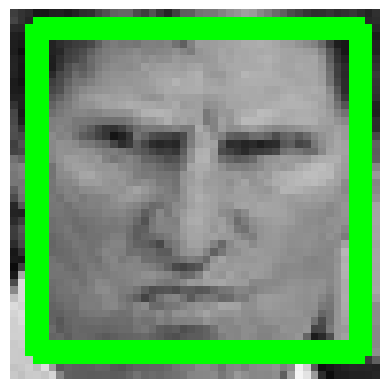

No additional faces detected within the ROI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


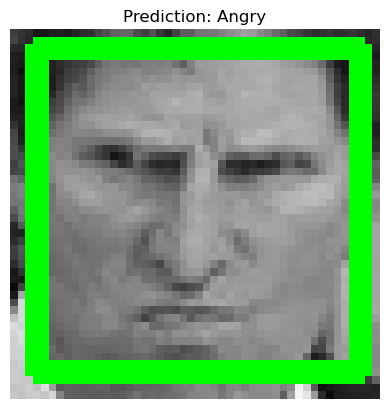

,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Curiosity,Beau Projet,Calm,60
2,Escaping Time,Benjamin Martins,Calm,60
3,Just Look at You,369,Calm,59
4,Vague,Amaranth Cove,Calm,59


In [32]:
pred_and_plot("MoodforMusic/test/angry/PrivateTest_7969511.jpg".replace("\\", "/"), Emotion_Classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


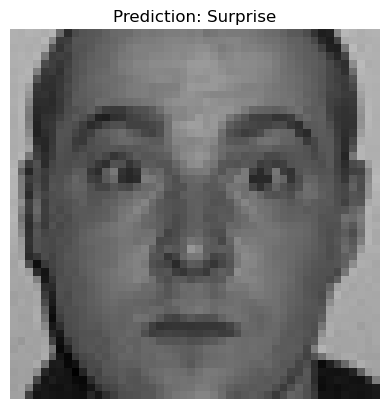

,name,artist,mood,popularity
0,Chop Suey!,System Of A Down,Energetic,79
1,Killing In The Name,Rage Against The Machine,Energetic,78
2,Dani California,Red Hot Chili Peppers,Energetic,77
3,Duality,Slipknot,Energetic,76
4,Uprising,Muse,Energetic,75


In [33]:
pred_and_plot("MoodforMusic/test/surprise/PrivateTest_11445412.jpg".replace("\\", "/"), Emotion_Classes)

In [34]:
import joblib
joblib.dump(CNN_Model,'Emotion_detection_model')

['Emotion_detection_model']

In [35]:
%%writefile app.py
import urllib.request
import streamlit as st
import pickle
import cv2
import pandas as pd
import joblib
import numpy as np
CNN_Model=joblib.load("Emotion_detection_model")

# Download the face detection model
url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"
filename = "haarcascade_frontalface_default.xml"
urllib.request.urlretrieve(url, filename)
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

# Load the music player data
Music_Player = pd.read_csv(r"C:\Users\jeten\Documents\Final Capstone Project\MoodforMusic\data_moods.csv")
Music_Player = Music_Player[["name", "artist", "mood", "popularity"]]

# Function to recommend songs based on predicted mood
def Recommend_Songs(pred_class):
    mood_map = {
        "Disgust": "Sad",
        "Happy": "Happy",
        "Sad": "Happy",
        "Fear": "Calm",
        "Angry": "Calm",
        "Surprise": "Energetic",
        "Neutral": "Energetic"
    }
    mood = mood_map.get(pred_class, "Happy")  # Default to "Happy" if pred_class not found
    Play = Music_Player[Music_Player["mood"] == mood]
    Play = Play.sort_values(by="popularity", ascending=False)
    Play = Play[:5].reset_index(drop=True)
    return Play

# Function to load and prepare an image
def load_and_prep_image(uploaded_file, img_shape=255):
    img = cv2.imdecode(np.fromstring(uploaded_file.read(), np.uint8), 1)
    if img is None:
        st.error(f"Error: Unable to load image at path {filename}")
        return None
    
    GrayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)
    for x, y, w, h in faces:
        roi_GrayImg = img[y: y + h, x: x + w]
        roi_Img = img[y: y + h, x: x + w]
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
    RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGBImg = cv2.resize(RGBImg, (img_shape, img_shape))
    RGBImg = RGBImg / 255.0
    return RGBImg

# Function to predict and plot the result
def pred_and_plot(uploaded_file, class_names):
    img = load_and_prep_image(uploaded_file)
    if img is None:
        return
    
    pred = CNN_Model.predict(np.expand_dims(img, axis=0))
    pred_class = class_names[pred.argmax()]
    
    st.image(img, caption=f"Prediction: {pred_class}")
    Play = Recommend_Songs(pred_class)
    st.dataframe(Play)

# Streamlit interface
st.title("Emotion-based Music Recommendation")
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])
class_names = ["Disgust", "Happy", "Sad", "Fear", "Angry", "Surprise", "Neutral"]

if uploaded_file is not None:
    pred_and_plot(uploaded_file, class_names)

Writing app.py
